# Clustering the Whole Set

## Preparation

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
from sklearn.metrics import adjusted_rand_score, silhouette_score
from scipy.cluster.hierarchy import dendrogram

from src import akeneo, akeneo_clustering as ac, clustering, config

In [2]:
cache = akeneo.create_cache_from_env()

In [3]:
data_dir = config.dir_data / "clustering-results" / "3-both"
data_dir.mkdir(parents=True, exist_ok=True)

In [26]:
mpl.rcParams['figure.dpi'] = 300

channel = "default"
lang = "en_US"

### Products

In [5]:
products = ac.parse_products(
    cache,
    attribute_types=ac.TYPES_NUMERICAL + ac.TYPES_CATEGORICAL + ac.TYPES_MULTI + ac.TYPES_TEXT,
)
products_multi_as_single = ac.transform_multi_to_single_cat(products)

n = len(products)

products_df = pd.DataFrame(products)
products_multi_as_single_df = pd.DataFrame(products_multi_as_single)

In [6]:
labels_families = products_df[ac.KEY_FAMILY].to_numpy()
k_families = len(set(labels_families))
pd.Series(labels_families).value_counts(), f"k = {k_families}"

(mobile_phone_cases    80
 smartphones           42
 dtype: int64,
 'k = 2')

In [7]:
labels_generations = []
labels_models = []

for _, family, categories, brand in products_df[[ac.KEY_FAMILY, ac.KEY_CATEGORIES, "icecat_brand_fixed"]].itertuples():
    if family == "mobile_phone_cases":
        labels_generations.append(f"{family}_{brand}_{categories[-1].split('_')[0]}")
        labels_models.append(f"{family}_{brand}_{categories[-1]}")
    else:
        labels_generations.append(f"{family}_{categories[-1].split('_')[0]}")
        labels_models.append(f"{family}_{categories[-1]}")

k_generations = len(set(labels_generations))
k_models = len(set(labels_models))

print(f"k={k_generations}")
print(f"k={k_models}")
pd.DataFrame([labels_generations, labels_models])

k=11
k=36


,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,120,121
0,mobile_phone_cases_mobiparts_s20,mobile_phone_cases_mobiparts_s20,mobile_phone_cases_mobiparts_s20,mobile_phone_cases_mobiparts_s20,mobile_phone_cases_mobiparts_s20,mobile_phone_cases_mobiparts_s20,mobile_phone_cases_mobiparts_s20,mobile_phone_cases_mobiparts_s20,mobile_phone_cases_mobiparts_s20,mobile_phone_cases_mobiparts_s20,...,smartphones_s21,smartphones_s21,smartphones_s21,smartphones_s21,smartphones_s21,smartphones_s21,smartphones_s22,smartphones_s22,smartphones_s22,smartphones_s22
1,mobile_phone_cases_mobiparts_s20,mobile_phone_cases_mobiparts_s20,mobile_phone_cases_mobiparts_s20,mobile_phone_cases_mobiparts_s20,mobile_phone_cases_mobiparts_s20,mobile_phone_cases_mobiparts_s20,mobile_phone_cases_mobiparts_s20,mobile_phone_cases_mobiparts_s20_plus,mobile_phone_cases_mobiparts_s20_plus,mobile_phone_cases_mobiparts_s20_plus,...,smartphones_s21_ultra,smartphones_s21_ultra,smartphones_s21_fe,smartphones_s21_fe,smartphones_s21_fe,smartphones_s21_fe,smartphones_s22,smartphones_s22,smartphones_s22_plus,smartphones_s22_ultra


In [8]:
labels_generations_shared = products_df[ac.KEY_CATEGORIES].map(lambda x: x[-1].split("_")[0]).to_numpy()
k_generations_shared = len(set(labels_generations_shared))
pd.Series(labels_generations_shared).value_counts(), f"k = {k_generations_shared}"

(s20    62
 s21    52
 s22     8
 dtype: int64,
 'k = 3')

In [9]:
labels_models_shared = products_df[ac.KEY_CATEGORIES].map(lambda x: x[-1]).to_numpy()
k_models_shared = len(set(labels_models_shared))
pd.Series(labels_models_shared).value_counts(), f"k = {k_models_shared}"

(s20          23
 s20_plus     19
 s21          18
 s20_ultra    15
 s21_plus     14
 s21_ultra    11
 s21_fe        9
 s20_fe        5
 s22           4
 s22_ultra     2
 s22_plus      2
 dtype: int64,
 'k = 11')

In [10]:
duplicates: dict[str, list[int]] = {}
for index, categories in products_df.to_dict()[ac.KEY_CATEGORIES].items():
    category = categories[0]
    if category[:4] != "dup_":
        continue

    if category not in duplicates:
        duplicates[category] = []
    duplicates[category].append(index)
duplicates

{'dup_s20': [81, 82],
 'dup_s20_ultra': [89, 90],
 'dup_s21_128': [98, 99],
 'dup_s21_256': [100, 101],
 'dup_s21_plus': [104, 105],
 'dup_s21_ultra': [112, 113]}

### Attributes

In [11]:
tmp = {
    "code": [],
    "name": [],
    "type": [],
    "typeclass": [],
    "required-cases": [],
    "required-phones": [],
    "non-null": [],
    "unique": [],
}

attr_cases = list(filter(lambda f: f.code == "mobile_phone_cases", cache.families))[0].attributes
attr_cases_req = list(filter(lambda f: f.code == "mobile_phone_cases", cache.families))[0].attribute_requirements[channel]
attr_phones = list(filter(lambda f: f.code == "smartphones", cache.families))[0].attributes
attr_phones_req = list(filter(lambda f: f.code == "smartphones", cache.families))[0].attribute_requirements[channel]

for attr_code, attr in akeneo.Attribute.to_dict(cache.attributes).items():
    if attr_code not in products_df.columns:
        continue

    tmp["code"].append(attr_code)
    tmp["name"].append(attr.labels[lang])
    tmp["type"].append(attr.type)
    tmp["typeclass"].append(ac.map_to_attribute_kind(attr.type))
    tmp["required-cases"].append(None if attr_code not in attr_cases else (attr_code in attr_cases_req))
    tmp["required-phones"].append(None if attr_code not in attr_phones else (attr_code in attr_phones_req))
    tmp["non-null"].append(products_df[attr_code].count())
    tmp["unique"].append(products_df[attr_code].drop_duplicates().count())

attr_df = pd.DataFrame(tmp)
attr_df.sort_values(["non-null", "unique"], ascending=[False, False])

,code,name,type,typeclass,required-cases,required-phones,non-null,unique
206,icecat_summary_short,Short Summary,AttributeType.TEXT,string,True,True,122,118
207,icecat_title,Title,AttributeType.TEXT,string,True,True,122,118
205,icecat_name,Name,AttributeType.TEXT,string,True,True,122,82
203,icecat_brand_fixed,Brand,AttributeType.SELECT_SINGLE,categorical,True,True,122,4
204,icecat_description_short,Short Description,AttributeType.TEXT,string,True,True,113,75
...,...,...,...,...,...,...,...,...
115,icecat_38332,Heart rate sensor,AttributeType.BOOL,categorical,None,False,1,1
139,icecat_4463_fixed,Package type,AttributeType.SELECT_SINGLE,categorical,False,None,1,1
142,icecat_4857,Battery weight,AttributeType.METRIC,numerical,None,False,1,1
162,icecat_762,Package weight,AttributeType.METRIC,numerical,None,False,1,1


In [12]:
cols = ["code", "typeclass", "required-cases", "required-phones"]
attr_df.fillna("null")[cols].groupby(cols[1:]).count().reset_index()

,typeclass,required-cases,required-phones,code
0,categorical,False,null,8
1,categorical,True,True,1
2,categorical,True,null,2
3,categorical,null,False,87
4,categorical,null,True,18
5,multi-categorical,True,null,1
6,multi-categorical,null,False,19
7,multi-categorical,null,True,3
8,numerical,False,False,3
9,numerical,False,True,1


In [13]:
attr_shared_df = attr_df[
    ~attr_df["required-cases"].isna() &
    ~attr_df["required-phones"].isna() &
    ~attr_df["code"].isin(["icecat_name"])
]
attr_codes_shared = attr_shared_df["code"].to_list()
attr_shared_df

,code,name,type,typeclass,required-cases,required-phones,non-null,unique
17,icecat_1464,Height,AttributeType.METRIC,numerical,False,False,64,22
30,icecat_1649,Width,AttributeType.METRIC,numerical,False,False,64,17
31,icecat_1650,Depth,AttributeType.METRIC,numerical,False,False,64,18
196,icecat_94,Weight,AttributeType.METRIC,numerical,False,True,64,22
203,icecat_brand_fixed,Brand,AttributeType.SELECT_SINGLE,categorical,True,True,122,4
204,icecat_description_short,Short Description,AttributeType.TEXT,string,True,True,113,75
206,icecat_summary_short,Short Summary,AttributeType.TEXT,string,True,True,122,118
207,icecat_title,Title,AttributeType.TEXT,string,True,True,122,118


### Clustering & Metrics

In [14]:
def _calc_duplicates_match(labels) -> float:
    result = 0.0
    n_duplicates = 0
    for _, indexes in duplicates.items():
        y1 = labels[indexes[0]]
        y2 = labels[indexes[1]]

        shared_clusters = len(y1.intersection(y2))
        all_clusters = len(y1.union(y2))

        result += (shared_clusters+1) / all_clusters
        n_duplicates += 1
    
    return result / n_duplicates

def calc_metrics(attr_codes, multi_as_single=False, attr_to_overweight: list[str] = None, factor = 2):
    dataset = (
        ac.dataset_from_records(products_df[attr_codes].to_dict("records"))
        if not multi_as_single
        else ac.dataset_from_records(products_multi_as_single_df[attr_codes].to_dict("records"))
    )
    prox_matrix = ac.calc_proximity_matrix(dataset)

    if attr_to_overweight is not None:
        dataset = ac.overweight_attributes(dataset, attr_to_overweight, factor)

    bik = clustering.BisectingKMeans(dataset, ac.Centroid, random_state=0)
    biks = [
        clustering.BisectingKMeans(dataset, ac.Centroid, random_state=i)
        for i in range(1, 11)
    ]

    stabilities = []
    for k in range(2, len(dataset) + 1):
        values = []
        for bikk in biks:
            values.append(
                adjusted_rand_score(
                    bik.labels_flat(k),
                    bikk.labels_flat(k),
                )
            )
        stabilities.append(np.array(values).mean())
    stabilities = np.array(stabilities)

    qualities = []
    for k in range(2, len(dataset)):
        qualities.append(silhouette_score(prox_matrix, bik.labels_flat(k), metric="precomputed"))
    qualities = np.array(qualities)

    return {
        "stabilities": stabilities,
        "qualities": qualities,
        "match_fam": adjusted_rand_score(labels_families, bik.labels_flat(k_families)),
        "match_gen": adjusted_rand_score(labels_generations, bik.labels_flat(k_generations)),
        "match_mod": adjusted_rand_score(labels_models, bik.labels_flat(k_models)),
        "match_gen_shared": adjusted_rand_score(labels_generations_shared, bik.labels_flat(k_generations_shared)),
        "match_mod_shared": adjusted_rand_score(labels_models_shared, bik.labels_flat(k_models_shared)),
        "match_dup": _calc_duplicates_match(bik.labels)
    }

In [15]:
def metrics_to_table(metric):
    return {
        "Stability": metric["stabilities"].mean(),
        "Quality": metric["qualities"].mean(),
        "Match Families": metric["match_fam"],
        "Match Generations": metric["match_gen"],
        "Match Models": metric["match_mod"],
        "Match Duplicates": metric["match_dup"],
        "Match Generations Shared": metric["match_gen_shared"],
        "Match Models Shared": metric["match_mod_shared"],
    }

## Clustering

In [16]:
attr_codes_types = {
    "numerical": attr_df[attr_df["typeclass"]=="numerical"]["code"].to_list(),
    "categorical": attr_df[attr_df["typeclass"]=="categorical"]["code"].to_list(),
    "multi": attr_df[attr_df["typeclass"]=="multi-categorical"]["code"].to_list(),
    "string": attr_df[attr_df["typeclass"]=="string"]["code"].to_list(),
    "num+cat": attr_df[attr_df["typeclass"].isin(["numerical", "categorical"])]["code"].to_list(),
    "num+cat+mul": attr_df[attr_df["typeclass"].isin(["numerical", "categorical", "multi"])]["code"].to_list(),
    "num+cat+str": attr_df[attr_df["typeclass"].isin(["numerical", "categorical", "string"])]["code"].to_list(),
    "num+cat+mul+str": attr_df[attr_df["typeclass"].isin(["numerical", "categorical", "multi", "string"])]["code"].to_list(),
}
pd.DataFrame([(key, value) for key, value in attr_codes_types.items()])

,0,1
0,numerical,"[icecat_11379, icecat_12435_fixed, icecat_1243..."
1,categorical,"[icecat_10157, icecat_1024_fixed, icecat_10399..."
2,multi,"[icecat_13248_fixed, icecat_14695_fixed, iceca..."
3,string,"[icecat_12434, icecat_1585, icecat_1597, iceca..."
4,num+cat,"[icecat_10157, icecat_1024_fixed, icecat_10399..."
5,num+cat+mul,"[icecat_10157, icecat_1024_fixed, icecat_10399..."
6,num+cat+str,"[icecat_10157, icecat_1024_fixed, icecat_10399..."
7,num+cat+mul+str,"[icecat_10157, icecat_1024_fixed, icecat_10399..."


In [17]:
attr_codes_selection_cases = [
    "icecat_6767", "icecat_1464", "icecat_1649", "icecat_1650",
    "icecat_title",
    "icecat_8156", "icecat_8778",
]
attr_codes_selection_phones = [
    # aspect, pixel density, display diagonal
    "icecat_13246_fixed",
    "icecat_11417",
    "icecat_944",
    # weight, h x w x d
    "icecat_94",
    "icecat_1464",
    "icecat_1649",
    "icecat_1650",
    # camera
    "icecat_12435_fixed",
    "icecat_12437_fixed",
    # mobile generation
    "icecat_40629",
    # platform, os installed
    "icecat_75_fixed",
    "icecat_3233",
    # title
    "icecat_title",
]
attr_codes_selection = pd.Series(attr_codes_selection_cases+attr_codes_selection_phones).drop_duplicates().to_list()

In [18]:
def metrics_make():
    return {
        **{
            key: calc_metrics(value)
            for key, value in attr_codes_types.items()
        },
        "selection": calc_metrics(attr_codes_selection),
        "all & selection x2": calc_metrics(attr_codes_types["num+cat+mul+str"], attr_to_overweight=attr_codes_selection, factor=2),
        "all & selection x3": calc_metrics(attr_codes_types["num+cat+mul+str"], attr_to_overweight=attr_codes_selection, factor=3),
        "num+cat & selection x2": calc_metrics(attr_codes_types["num+cat"], attr_to_overweight=attr_codes_selection, factor=2),
        "num+cat & selection x3": calc_metrics(attr_codes_types["num+cat"], attr_to_overweight=attr_codes_selection, factor=3),
        "only shared": calc_metrics(attr_codes_shared)
    }
metrics = config.load_or_create(data_dir / "metrics.pkl", metrics_make)

In [19]:
pd.DataFrame({key: metrics_to_table(met) for key, met in metrics.items()}).transpose().style.highlight_max(color="lightgreen")

,Stability,Quality,Match Families,Match Generations,Match Models,Match Duplicates,Match Generations Shared,Match Models Shared
numerical,0.894818,0.469649,1.000000,0.416172,0.426504,0.972222,0.056095,0.250731
categorical,0.720958,0.412605,1.000000,0.671059,0.367799,0.849603,0.073443,0.122622
multi,0.832481,0.485027,-0.039587,0.447265,0.195353,0.944444,0.002086,0.066618
string,0.883822,0.255305,1.000000,0.605996,0.575331,1.000000,0.055277,0.135106
num+cat,0.799751,0.492032,1.000000,0.589404,0.657616,0.966667,0.001236,0.168523
num+cat+mul,0.799751,0.492032,1.000000,0.589404,0.657616,0.966667,0.001236,0.168523
num+cat+str,0.940569,0.328978,1.000000,0.736665,0.644019,0.972222,0.006256,0.153648
num+cat+mul+str,0.940569,0.328978,1.000000,0.736665,0.644019,0.972222,0.006256,0.153648
selection,0.920109,0.339207,1.000000,0.405720,0.629981,0.966667,0.056095,0.268568
all & selection x2,0.953677,0.325608,1.000000,0.788308,0.708328,0.966667,0.064923,0.164448


,Stability,Quality,Match Families,Match Generations,Match Models,Match Duplicates,Match Generations Shared,Match Models Shared
num+cat,0.80,0.49,1.0,0.59,0.66,0.97,0.00,0.17
all & selection x2,0.95,0.33,1.0,0.79,0.71,0.97,0.06,0.16
num+cat & selection x2,0.91,0.49,1.0,0.71,0.70,0.97,0.06,0.18
string,0.88,0.26,1.0,0.61,0.58,1.00,0.06,0.14


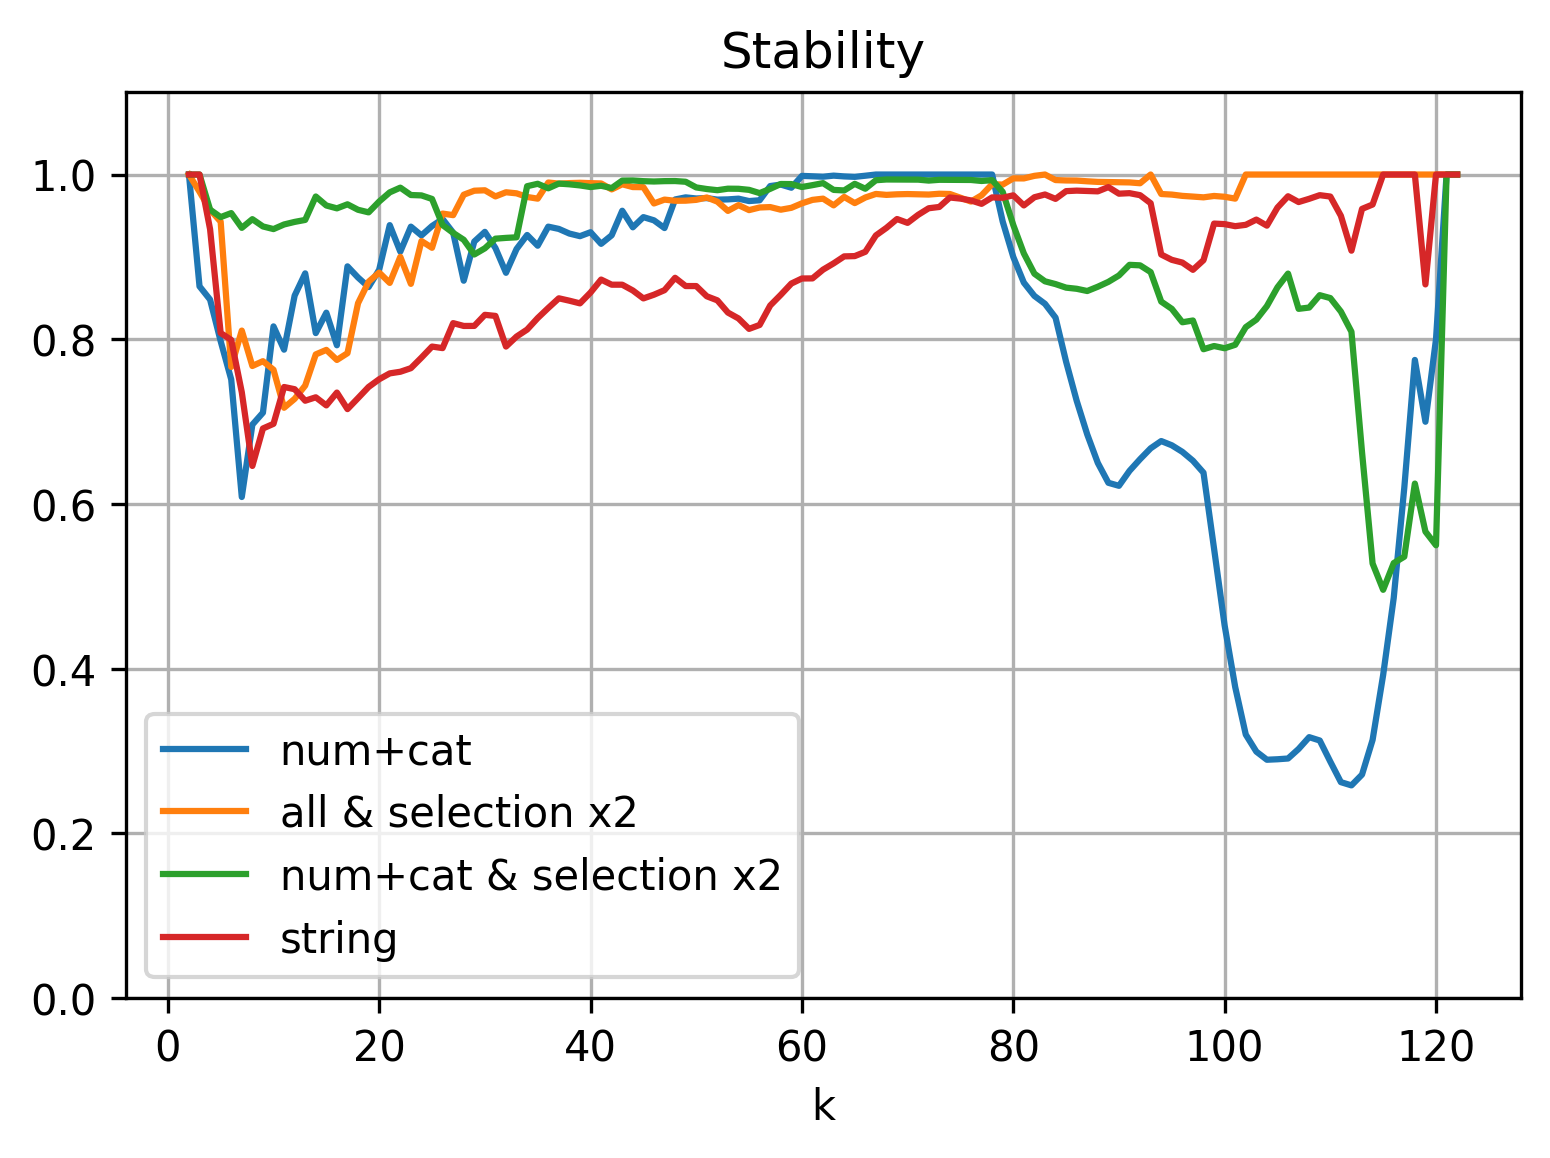

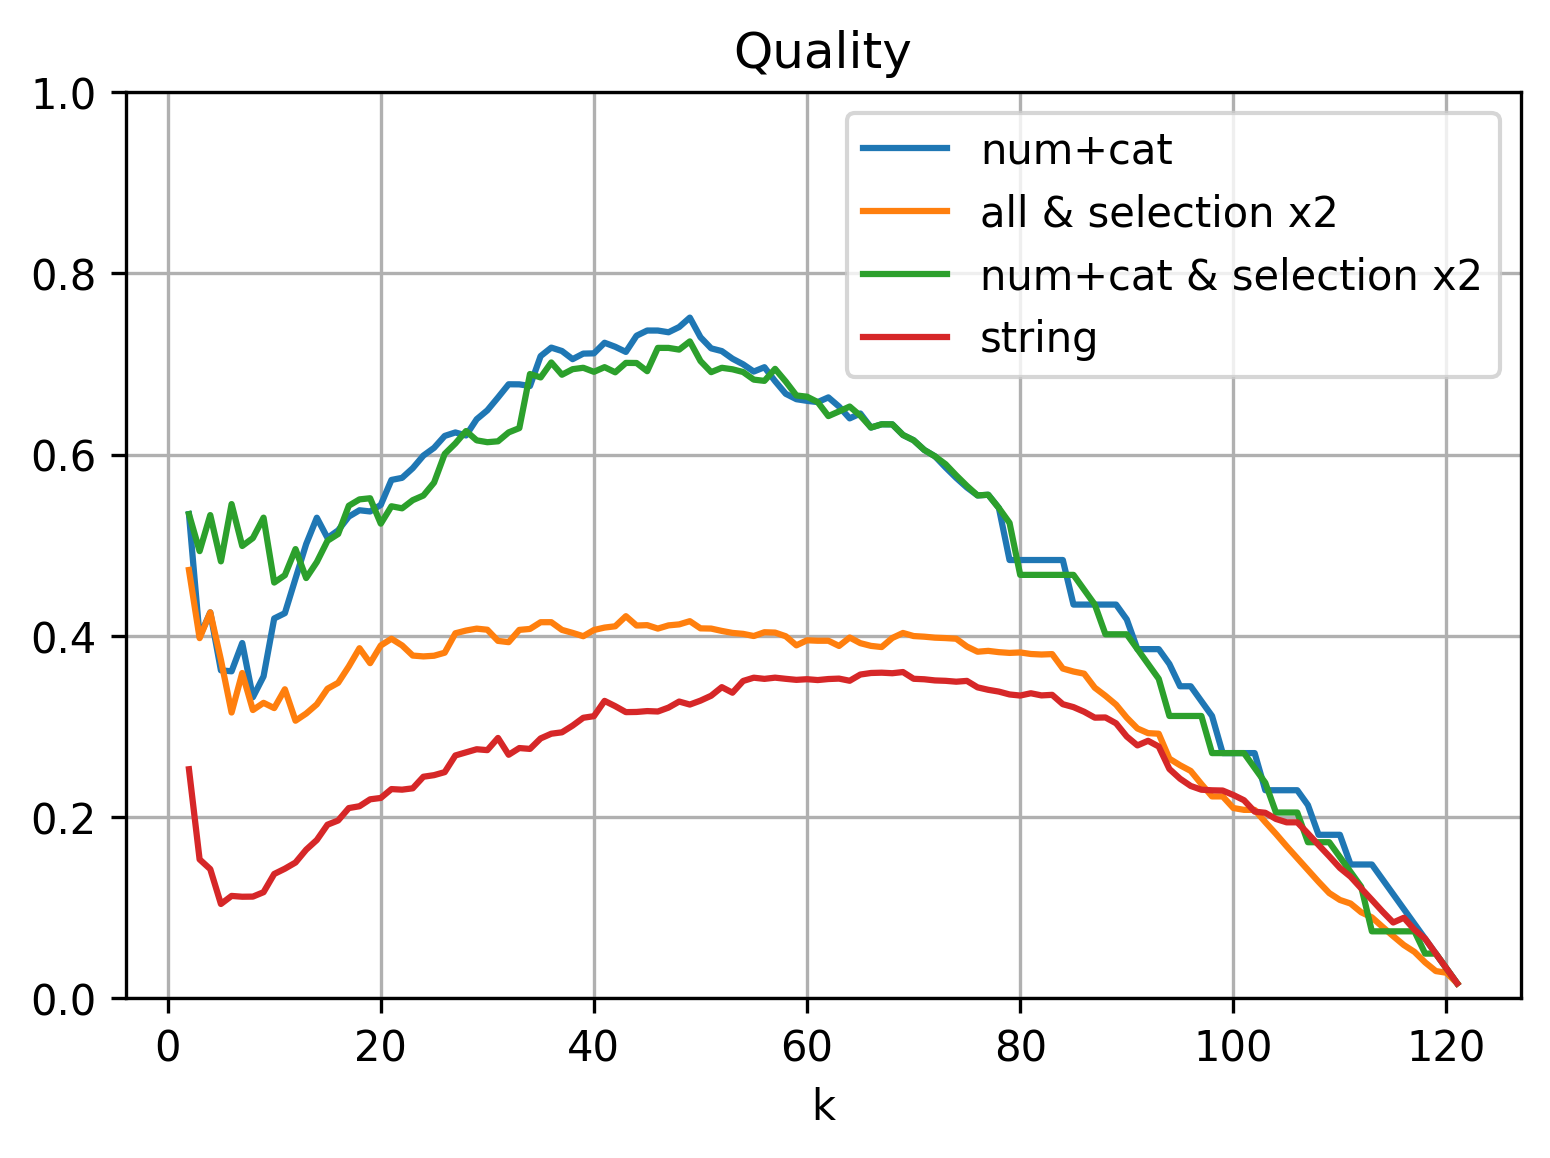

In [27]:
i = ["num+cat", "all & selection x2", "num+cat & selection x2", "string"]
pd.DataFrame({
    key: metrics[key]["stabilities"]
    for key in i
}, index=range(2, n+1)).plot.line(title="Stability", ylim=(0,1.1), xlabel="k", grid=True)
pd.DataFrame({
    key: metrics[key]["qualities"]
    for key in i
}, index=range(2, n)).plot.line( title="Quality", ylim=(0,1), xlabel="k", grid=True)
pd.DataFrame({key: metrics_to_table(metrics[key]) for key in i}).transpose().round(2)

<AxesSubplot:title={'center':'Clustering with shared attributes'}, xlabel='k'>

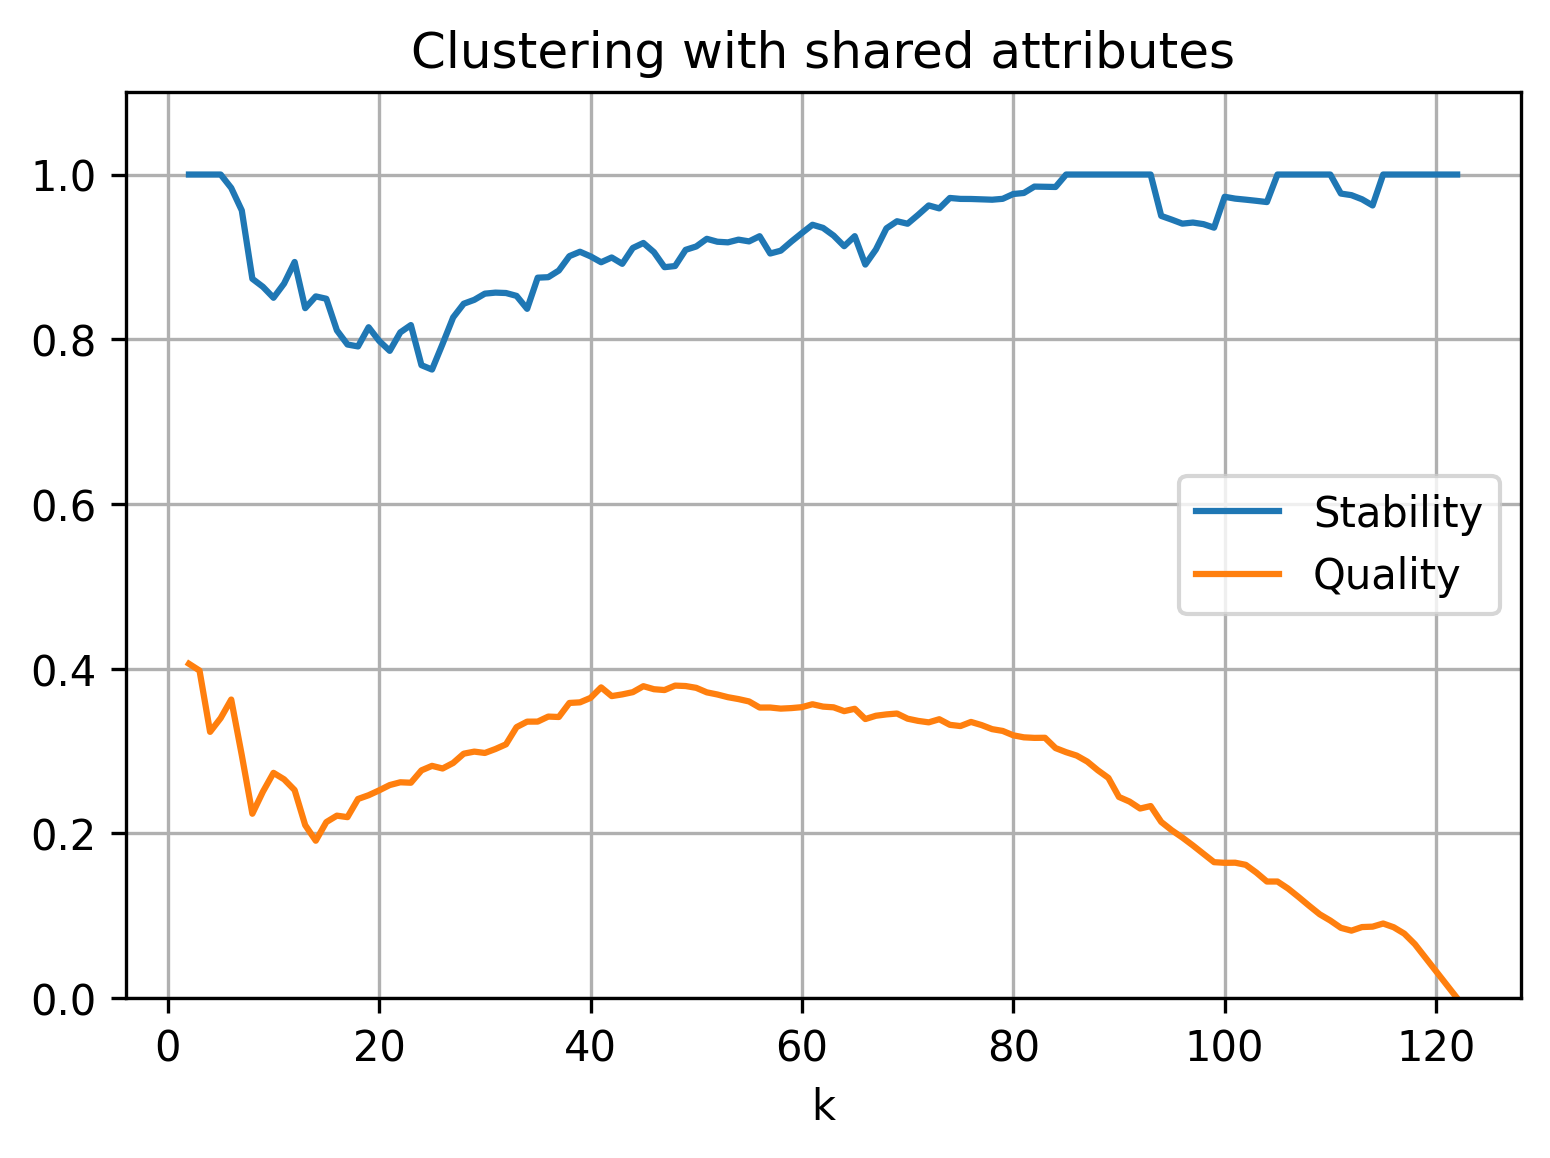

In [28]:
pd.DataFrame({
    "Stability": metrics["only shared"]["stabilities"],
    "Quality": metrics["only shared"]["qualities"].tolist()+[0],
}, index=range(2, n+1)).plot.line( title="Clustering with shared attributes", ylim=(0,1.1), xlabel="k", grid=True)

## Sonstiges

In [22]:
dataset = ac.dataset_from_records(products_df[attr_codes_types["num+cat"]].to_dict("records"))
bik_num_cat = clustering.BisectingKMeans(dataset, ac.Centroid, random_state=0)

In [23]:
pd.DataFrame({
    "title": products_df["icecat_title"].to_list(),
    "family": products_df[ac.KEY_FAMILY].to_list(),
    "cluster": bik_num_cat.labels_flat(2),
}).groupby(["family", "cluster"]).count()

,,title
family,cluster,
mobile_phone_cases,0,80
smartphones,1,42


In [24]:
pd.DataFrame({
    "title": products_df["icecat_title"].to_list(),
    "generation": labels_generations,
    "cluster": bik_num_cat.labels_flat(k_generations),
}).groupby(["generation", "cluster"]).count()

title
generation                          cluster       
mobile_phone_cases_cellularline_s20 0            4
                                    5            1
mobile_phone_cases_cellularline_s21 0            6
mobile_phone_cases_mobiparts_s20    0           12
                                    9            1
mobile_phone_cases_mobiparts_s21    2            6
                                    9            9
mobile_phone_cases_panzerglass_s20  3            4
mobile_phone_cases_panzerglass_s22  3            4
mobile_phone_cases_samsung_s20      6           23
mobile_phone_cases_samsung_s21      2            9
                                    6            1
smartphones_s20                     1           14
                                    10           3
smartphones_s21                     1            9
                                    4            4
                                    7            6
                                    8            2
smartphones_s22                     4            3
                                    7            1

In [25]:
tmp_df = products_df.copy()
tmp_df["cluster_gen"] = bik_num_cat.labels_flat(k_generations)
tmp_df[tmp_df["cluster_gen"].isin([5,9])]

,__id__,__family__,__categories__,icecat_8156,icecat_8411,icecat_8778,icecat_27575_fixed,icecat_brand_fixed,icecat_name,icecat_title,...,icecat_9040,icecat_28715,icecat_42370_fixed,icecat_42371_fixed,icecat_42372_fixed,icecat_1535,icecat_4857,icecat_10399,icecat_38332,cluster_gen
12,MP-110885,mobile_phone_cases,[s20_fe],348496968,348496965,367987544,NaN,mobiparts,"{tpu, classic}","{classic, case, 6.5, mobipart, tpu, transpar, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
13,MP-112908,mobile_phone_cases,[s21],348496968,348496965,367987544,NaN,mobiparts,{mp-112908},"{mp-112908, 6.2, mobipart, black, mobil, cover...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
14,MP-112914,mobile_phone_cases,[s21],348496968,348496965,367987544,NaN,mobiparts,{mp-112914},"{blue, mp-112914, 6.2, mobipart, mobil, cover,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
15,MP-112920,mobile_phone_cases,[s21],348496968,348496965,367987544,NaN,mobiparts,{mp-112920},"{6.2, mobipart, red, mp-112920, mobil, cover, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
16,MP-112944,mobile_phone_cases,[s21],348496968,348496965,367987544,NaN,mobiparts,"{tpu, classic}","{classic, case, mobipart, tpu, transpar, 6.8, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
17,MP-112940,mobile_phone_cases,[s21],348496968,348496965,367987544,NaN,mobiparts,{mp-112940},"{case, 6.2, mobipart, transpar, mobil, cover, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
18,MP-112939,mobile_phone_cases,[s21],348496968,348496965,367987544,NaN,mobiparts,{mp-112939},"{mp-112939, 6.2, mobipart, black, mobil, cover...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
25,MP-117810,mobile_phone_cases,[s21_fe],348496968,348496965,367987544,NaN,mobiparts,"{tpu, classic}","{classic, case, 6.41, mobipart, tpu, transpar,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
26,MP-121901,mobile_phone_cases,[s21_fe],348496968,348496965,367987544,NaN,mobiparts,{mp-121901},"{mp-121901, 6.4, mobipart, black, mobil, cover...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
27,MP-121895,mobile_phone_cases,[s21_fe],NaN,348496965,367987544,NaN,mobiparts,{mp-121895},"{6.4, mobipart, black, mobil, cover, phone, ca...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
